In [ ]:
%cd supervised
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import models
import torch
import seaborn as sns

/home/maarten/Documents/masterthesis/supervised


In [1]:
import pickle

def save(data, fname):
    with open(fname, 'wb') as f:
        pickle.dump(data, f)
    
def load(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [ ]:
dataset1, validset1, testset1 = evaluate.load_dataset(9, 0, 1, True)
dataset2, validset2, testset2 = evaluate.load_dataset(9, 1, 1, True)

In [ ]:
import numpy as np
from collections import Counter
print(Counter(np.shape(s.clusters_gmm)[1] for s in dataset1))
print(Counter(np.shape(s.clusters_gmm)[1] for s in dataset2))

In [ ]:
assert(len([d.label for d in dataset1 if np.all(d.label == 1)])
       ==len([d.label for d in dataset1 if np.all(d.label == 0)]))

for d1, d2 in zip(dataset1, dataset2):
    assert(np.all([w in d2.X_words for w in np.nditer(d1.X_words)]))
    assert(np.all([w in d2.X_chars for w in np.nditer(d1.X_chars)]))
    assert(np.all(d1.label == d2.label))

# Training size, full cross validation

In [ ]:
# main test

window_size = 2
num_clusters = 9
dataset, validset = load_dataset(num_clusters, window_size)

params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]

baseline = {}
kmeans = {}
gmm = {}

for n in [50, 100, 400, 800, 1200, 1600, 2000, 2400]:
    values = evaluate.cross_val(10, n, model_fns, [False, False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=None)
    baseline[n] = [v[0] for v in values]
    kmeans[n] = [v[1] for v in values]
#    gmm[n] = [v[2] for v in values]

In [ ]:
d = {s: {'Baseline': baseline[s],
         'K-Means': kmeans[s],
#         'Mixture model': gmm[s],
        }
    for s in baseline.keys()
}
evaluate.analyze_tseries(d, 'number of training samples', 'model', '../report/figures/results/main_window4_oldtest')
evaluate.analyze_size(d, 'number of samples', 'model', '../report/figures/results/main_window4_oldtest')

In [ ]:
evaluate.analyze_wrapper(baseline, kmeans, None, 'model', '../report/figures/results/main_window4_data_oldtest')
#evaluate.analyze_wrapper(baseline, kmeans, gmm, 'model')

# Bag of words, older test set

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

num_clusters = 9
window_size = (0, 1)
k = 5


bow_s = {}
only_kmeans_s = {}
only_gmm_s = {}

for training_size in [100, 200, 400, 800, 1200, 1600, 2000, 2400]:
    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True,
                                                       bag_of_words=True)
    splitter = evaluate.StratifiedShuffleSplit(
        n_splits=k,
        train_size=training_size,
        test_size=None,
        random_state=100,
    )

    splitter.random_state = 100
    values = evaluate.cross_val_bow(k, splitter, dataset, testset=testset)
    bow_s[training_size] = [v[0] for v in values]

    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.OnlyClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.OnlyClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)
    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, True], optim_fn,
                                dataset,
                                params=[params, params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    only_kmeans_s[training_size] = [v[0] for v in values]
    only_gmm_s[training_size] = [v[1] for v in values]

In [ ]:
import seaborn as sns
d = {
        s: {
            'Bag of words': bow_s[s],
            'Only K-Means': only_kmeans_s[s],
            'Only Mixture Model': only_gmm_s[s],
        }
    for s in bow_s.keys()
}

with sns.axes_style("darkgrid"):
    evaluate.analyze_tseries(d, "window_size", "model")
    #evaluate.analyze_cnns(d, "num. training samples", "model", "../report/figures/results/training-size-old")

# Training size, older test set

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

num_clusters = 9
window_size = (0, 1)
k = 5

#old_baseline_s = {}
#old_kmeans_s = {}
#old_gmm_s = {}
#old_char_baseline_s = {}
#old_char_kmeans_s = {}
#old_char_gmm_s = {}


for training_size in [100, 200]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)
    splitter = evaluate.StratifiedShuffleSplit(
        n_splits=k,
        train_size=training_size,
        test_size=None,
        random_state=100,
    )

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, False, True, False, False, True], optim_fn,
                                dataset,
                                params=[params, params, params, char_params, char_params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    
    old_baseline_s[training_size] = [v[0] for v in values]
    old_kmeans_s[training_size] = [v[1] for v in values]
    old_gmm_s[training_size] = [v[2] for v in values]
    old_char_baseline_s[training_size] = [v[3] for v in values]
    old_char_kmeans_s[training_size] = [v[4] for v in values]
    old_char_gmm_s[training_size] = [v[5] for v in values]

In [ ]:
import seaborn as sns
d = {
    "WordCNN": {
        s: {
            'K-Means': old_kmeans_s[s],
            'Infinite Mixture Model': old_gmm_s[s],
            'Baseline': old_baseline_s[s],
        }
        for s in old_kmeans_s.keys()
    },
    "CharCNN": {
        s: {
            'K-Means': old_char_kmeans_s[s],
            'Infinite Mixture Model': old_char_gmm_s[s],
            'Baseline': old_char_baseline_s[s],
        }
        for s in old_kmeans_s.keys()
    }
}

with sns.axes_style("darkgrid"):
    #evaluate.analyze_cnns(d, "window_size", "model")
    evaluate.analyze_cnns(d, "num. training samples", "model", "../report/figures/results/training-size-old")

In [ ]:
save((old_baseline_s, old_kmeans_s, old_gmm_s, old_char_baseline_s, old_char_kmeans_s, old_char_gmm_s), "training-size-old.pkl")

# Window size, full cross validation

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=100,
    max_norm=3,
)

#optim_fn = lambda p: torch.optim.Adadelta(p)
optim_fn = lambda p: torch.optim.Adam(p, weight_decay=0.0001)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
             
             lambda r: models.NoClusterLabels(r, char_params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, char_params.dropout)]
    
#baseline = {}
#kmeans = {}
#char_baseline = {}
#char_kmeans = {}

for window_size in [1]:
    num_clusters = 9
    dataset, validset = evaluate.load_dataset(num_clusters, window_size)

    values = evaluate.cross_val(5, 1600, model_fns, [False, False, False, False], optim_fn, dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=10,
                                validation_set=None,
                                batch_size=128,
                                testset=None)
    baseline[window_size] = [v[0] for v in values]
    kmeans[window_size] = [v[1] for v in values]
    char_baseline[window_size] = [v[2] for v in values]
    char_kmeans[window_size] = [v[3] for v in values]

In [ ]:
d = {
    "WordCNN": {
        s: {
            'Baseline': baseline[s],
            'K-Means': kmeans[s],
        }
        for s in baseline.keys()
    },
    "CharCNN": {
        s: {
            'Baseline': char_baseline[s],
            'K-Means': char_kmeans[s],
        }
        for s in baseline.keys()
    }
}
#evaluate.analyze_tseries(d, 'window size', 'model')
evaluate.analyze_cnns(d, "window size", "model", "../report/figures/results/1600-windowsize")

# Window size, older testset

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

num_clusters = 9
k = 1
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=2000,
    test_size=None,
    random_state=100,
)

old_kmeans_w = {}
old_gmm_w = {}
old_char_kmeans_w = {}
old_char_gmm_w = {}
old_baseline_w = {}
old_char_baseline_w = {}

for window_size in [(0, 0), (0, 1), (0, 2), (0, 3)]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, False, True, False, False, True], optim_fn,
                                dataset,
                                params=[params, params, params, char_params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset,
                               )
    old_baseline_w[window_size] = [v[0] for v in values]
    old_kmeans_w[window_size] = [v[1] for v in values]
    old_gmm_w[window_size] = [v[2] for v in values]
    old_char_baseline_w[window_size] = [v[3] for v in values]
    old_char_kmeans_w[window_size] = [v[4] for v in values]
    old_char_gmm_w[window_size] = [v[5] for v in values]

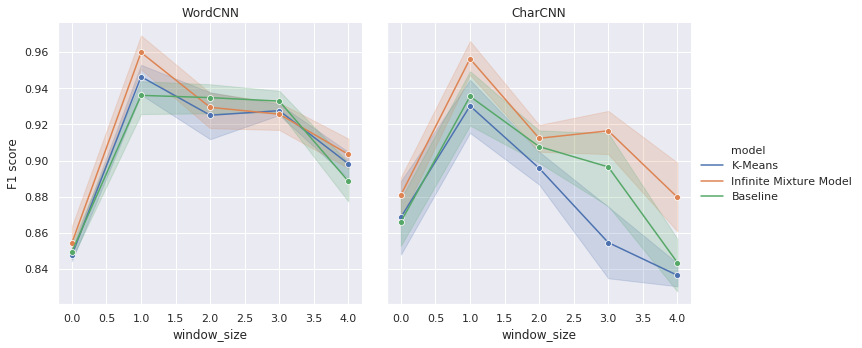

In [20]:
d = {
    "WordCNN": {
        sum(s): {
            'K-Means': old_kmeans_w[s],
            'Infinite Mixture Model': old_gmm_w[s],
            'Baseline': old_baseline_w[s],
        }
        for s in old_kmeans_w.keys()
    },
    "CharCNN": {
        sum(s): {
            'K-Means': old_char_kmeans_w[s],
            'Infinite Mixture Model': old_char_gmm_w[s],
            'Baseline': old_char_baseline_w[s],
        }
        for s in old_kmeans_w.keys()
    }
}
evaluate.analyze_cnns(d, "window_size", "model")
#evaluate.analyze_cnns(d, "window size", "model", "../report/figures/results/2000-windowsize_forward-old-center")

In [ ]:
save((old_baseline, old_kmeans_w, old_gmm_w, old_char_baseline, old_char_kmeans_w, old_char_gmm_w), "2000-windowsize-old.pkl")

In [5]:
(old_baseline_w, old_kmeans_w, old_gmm_w, old_char_baseline_w, old_char_kmeans_w, old_char_gmm_w) = load("2000-windowsize-old.pkl")

# Testing just CharCNN with various cluster configurations

In [8]:
char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

num_clusters = 9
k = 5
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=1600,
    test_size=None,
    random_state=100,
)


char_kmeans_center = {}
char_gmm_center = {}

for window_size in [(0, 1), (0, 2), (0, 3), (0, 4)]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.CategoricalClusterLabels(r, num_clusters, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True,
                                                       cluster_handling=data.ClusterHandling.CENTER)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, True], optim_fn,
                                dataset,
                                params=[char_params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset,
                               )

    char_kmeans_center[window_size] = [v[0] for v in values]
    char_gmm_center[window_size] = [v[1] for v in values]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.74it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[3746 3675 1630 ... 2254  624 3341]
1600 training samples, 1132 testing samples


Training:  22%|██▎       | 45/200 [00:35<02:01,  1.28it/s, f1=0.958, Δf1=-0.000125]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[3798 2533 2593 ... 1234 2358   38]


Training:  15%|█▌        | 30/200 [00:24<02:21,  1.20it/s, f1=0.933, Δf1=-0.00621]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[2472 1482 1743 ...  975  578  448]


Training:  20%|██        | 40/200 [00:34<02:16,  1.17it/s, f1=0.939, Δf1=-0.00042]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[ 233  185  786 ... 3685 1281 3021]


Training:  15%|█▌        | 30/200 [00:23<02:10,  1.30it/s, f1=0.918, Δf1=-0.000517]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[1998 1074 1940 ... 3007 3661 1936]


Training:  12%|█▎        | 25/200 [00:19<02:13,  1.31it/s, f1=0.933, Δf1=-0.00518]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.89it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[3746 3675 1630 ... 2254  624 3341]
1600 training samples, 1132 testing samples


Training:  18%|█▊        | 35/200 [00:31<02:27,  1.12it/s, f1=0.905, Δf1=-0.000275]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[3798 2533 2593 ... 1234 2358   38]


Training:  15%|█▌        | 30/200 [00:26<02:30,  1.13it/s, f1=0.897, Δf1=-0.00576]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[2472 1482 1743 ...  975  578  448]


Training:  25%|██▌       | 50/200 [00:44<02:13,  1.12it/s, f1=0.906, Δf1=-0.000932]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[ 233  185  786 ... 3685 1281 3021]


Training:  20%|██        | 40/200 [00:35<02:22,  1.12it/s, f1=0.893, Δf1=-0.00117]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[1998 1074 1940 ... 3007 3661 1936]


Training:  25%|██▌       | 50/200 [00:44<02:14,  1.12it/s, f1=0.93, Δf1=-0.00303] 

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.77it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[3746 3675 1630 ... 2254  624 3341]
1600 training samples, 1132 testing samples


Training:  35%|███▌      | 70/200 [01:09<02:08,  1.01it/s, f1=0.931, Δf1=-0.000344]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[3798 2533 2593 ... 1234 2358   38]


Training:  38%|███▊      | 75/200 [01:14<02:04,  1.01it/s, f1=0.925, Δf1=0]        

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[2472 1482 1743 ...  975  578  448]


Training:  22%|██▎       | 45/200 [00:44<02:33,  1.01it/s, f1=0.902, Δf1=-0.00272] 

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[ 233  185  786 ... 3685 1281 3021]


Training:  32%|███▎      | 65/200 [01:04<02:14,  1.01it/s, f1=0.935, Δf1=-0.00225]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[1998 1074 1940 ... 3007 3661 1936]


Training:  18%|█▊        | 35/200 [00:35<02:45,  1.00s/it, f1=0.904, Δf1=-0.00181]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.78it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[3746 3675 1630 ... 2254  624 3341]
1600 training samples, 1132 testing samples


Training:  32%|███▎      | 65/200 [01:10<02:27,  1.09s/it, f1=0.905, Δf1=-0.000466]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[3798 2533 2593 ... 1234 2358   38]


Training:  25%|██▌       | 50/200 [00:54<02:44,  1.10s/it, f1=0.929, Δf1=-0.000803]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[2472 1482 1743 ...  975  578  448]


Training:  20%|██        | 40/200 [00:43<02:54,  1.09s/it, f1=0.918, Δf1=-0.00145]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[ 233  185  786 ... 3685 1281 3021]


Training:  30%|███       | 60/200 [01:06<02:34,  1.11s/it, f1=0.93, Δf1=-0.000898]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

[1998 1074 1940 ... 3007 3661 1936]


Training:  15%|█▌        | 30/200 [00:33<03:07,  1.11s/it, f1=0.921, Δf1=-0.00332]

100%|██████████| 5/5 [07:55<00:00, 95.10s/it]


In [9]:
save((char_kmeans_concat, char_gmm_concat, char_kmeans_mean, char_gmm_mean, char_kmeans_center, char_gmm_center),
     "cluster_handling.pkl")

In [21]:
(char_kmeans_concat, char_gmm_concat, char_kmeans_mean, char_gmm_mean, char_kmeans_center, char_gmm_center) = load("cluster_handling.pkl")

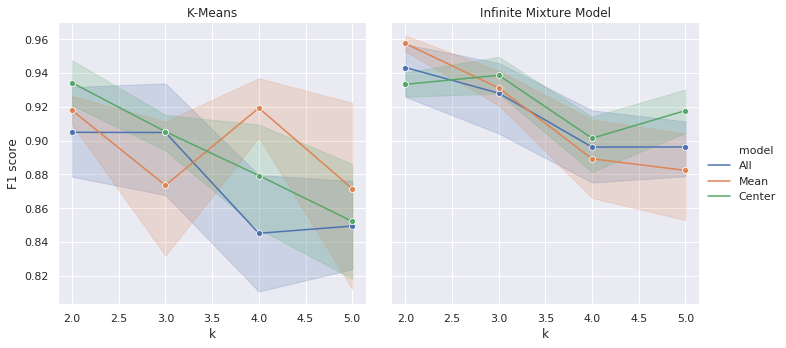

In [27]:
d = {
    "K-Means": {
        sum(s) + 1: {
            "All": char_kmeans_concat[s],
            "Mean": char_kmeans_mean[s],
            "Center": char_kmeans_center[s],
        }
        for s in char_kmeans_concat.keys()
    },

    "Infinite Mixture Model": {
        sum(s) + 1: {
            "All": char_gmm_concat[s],
            "Mean": char_gmm_mean[s],
            "Center": char_gmm_center[s],
        }
        for s in char_kmeans_concat.keys()
    },
}
with sns.axes_style("darkgrid"):
    evaluate.analyze_cnns(d, "k", "model")
    #evaluate.analyze_cnns(d, "k", "model", "../report/figures/results/1600-windowsize-variations")

# Number of clusters, full cross validation

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
    
kmeans = {}
gmm = {}

for num_clusters in [2, 3, 5, 7, 9, 15, 30]:
    window_size = 5
    dataset, validset = load_dataset(num_clusters, window_size)

    values = evaluate.cross_val(10, 1200, model_fns, [False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=None)
    kmeans[num_clusters] = [v[0] for v in values]
    gmm[num_clusters] = [v[1] for v in values]

In [ ]:
d = {s: {'K-Means': kmeans[s],
         #'Mixture model': gmm[s],
        }
    for s in kmeans.keys()
}
#evaluate.analyze_tseries(d, 'k', 'model')
evaluate.analyze_size(d, 'k', 'model', '../report/figures/results/800-numcluster')
evaluate.analyze_tseries(d, 'k', 'model', '../report/figures/results/800-numcluster')

# Number of clusters on old training set

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

window_size = (0, 1)
k = 5
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=2000,
    test_size=None,
    random_state=100,
)

old_kmeans_cls = {}
old_gmm_cls = {}
old_char_kmeans_cls = {}
old_char_gmm_cls = {}

for num_clusters in [2, 3, 5, 7, 9, 15, 30]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, True, False, True], optim_fn,
                                dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    old_kmeans_cls[num_clusters] = [v[0] for v in values]
    old_gmm_cls[num_clusters] = [v[1] for v in values]
    old_char_kmeans_cls[num_clusters] = [v[2] for v in values]
    old_char_gmm_cls[num_clusters] = [v[3] for v in values]

In [ ]:
(old_kmeans_cls, old_gmm_cls, old_char_kmeans_cls, old_char_gmm_cls) = load("1600-numclusters-old.pkl")

In [ ]:
d = {
    "WordCNN": {
        s: {
            'K-Means': old_kmeans_cls[s],
            'Infinite Mixture Model': old_gmm_cls[s],
        }
        for s in old_kmeans_cls.keys()
    },
    "CharCNN": {
        s: {
            'K-Means': old_char_kmeans_cls[s],
            'Infinite Mixture Model': old_char_gmm_cls[s],
        }
        for s in [2, 3, 5, 7, 9, 15]
    }
}
with sns.axes_style("darkgrid"):
    #evaluate.analyze_cnns(d, "k", "model")
    evaluate.analyze_cnns(d, "k", "model", "../report/figures/results/2000-numclusters-old")

In [ ]:
save((old_kmeans_cls, old_gmm_cls, old_char_kmeans_cls, old_char_gmm_cls), "2000-numclusters-old.pkl")